In [94]:
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

## Part 1. Toy dataset “Will They? Won’t They?”

In [95]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

### Train data

In [96]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

In [97]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


### Test data

In [98]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,True,False,True,False,True,False,False,True
1,True,False,False,True,False,True,True,False
2,False,True,False,True,True,False,False,True


In [99]:
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Money_spent_little,Eloquence_average,Alcoholic_beverage_no,Looks_repulsive,Alcoholic_beverage_yes,Eloquence_high,Looks_handsome,Money_spent_lots
0,False,False,False,False,True,True,True,True
1,True,False,False,False,True,False,True,False
2,False,True,True,False,False,False,True,True
3,True,True,True,True,False,False,False,False
4,False,False,False,True,True,False,False,True
5,False,False,False,True,True,True,False,True
6,False,True,False,False,True,False,True,True


#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [100]:
dt = DecisionTreeClassifier(criterion="entropy", random_state=17, max_depth=2)
dt.fit(df_train, y)
dt.predict(df_test)

array([0, 1, 0])

In [101]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    # needs graphviz to be installed
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

tree_graph_to_png(
    tree=dt,
    feature_names=df_test.columns.to_numpy(),
    png_file_to_save="assigment_03_demo.png",
)

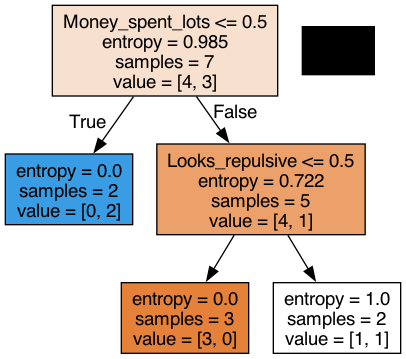

## Part 2. Functions for calculating entropy and information gain

In [102]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow
balls, balls_left, balls_right

([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0])

Implement a function to calculate the Shannon Entropy

In [103]:
import numpy as np
from collections import defaultdict

def entropy(a_list):
    lst = list(a_list)
    dist_table = {}
    entropy = 0

    if len(set(lst)) <= 1:
        return 0

    for i in lst:
        if i in dist_table:
            dist_table[i] += 1
        else:
            dist_table[i] = 1
            

    for key, val in dist_table.items():
        p_i = val / len(lst)
        entropy -= p_i * np.log2(p_i)

    return entropy

In [104]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


In [105]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""

    inf_gain = entropy(root) - 1.0 * (len(left) / len(root)) * entropy(left) \
         - 1.0 * (len(right) / len(root)) * entropy(right) 
    return inf_gain

In [106]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


## Part 3. The “Adult” dataset

In [107]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [108]:
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")
data_test.sample(random_state=17, n = 5)

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
10988,34,Private,35743.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4902,61,Local-gov,224711.0,Bachelors,13.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,63.0,United-States,>50K.
3753,24,Private,161415.0,11th,7.0,Never-married,Other-service,Other-relative,White,Male,0.0,0.0,35.0,United-States,<=50K.
393,48,Local-gov,188741.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,50.0,United-States,<=50K.
16244,42,Private,275677.0,Assoc-voc,11.0,Married-civ-spouse,Adm-clerical,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.


In [109]:
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

In [110]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
data_train["Target"].value_counts()

Target
0    24720
1     7841
Name: count, dtype: int64

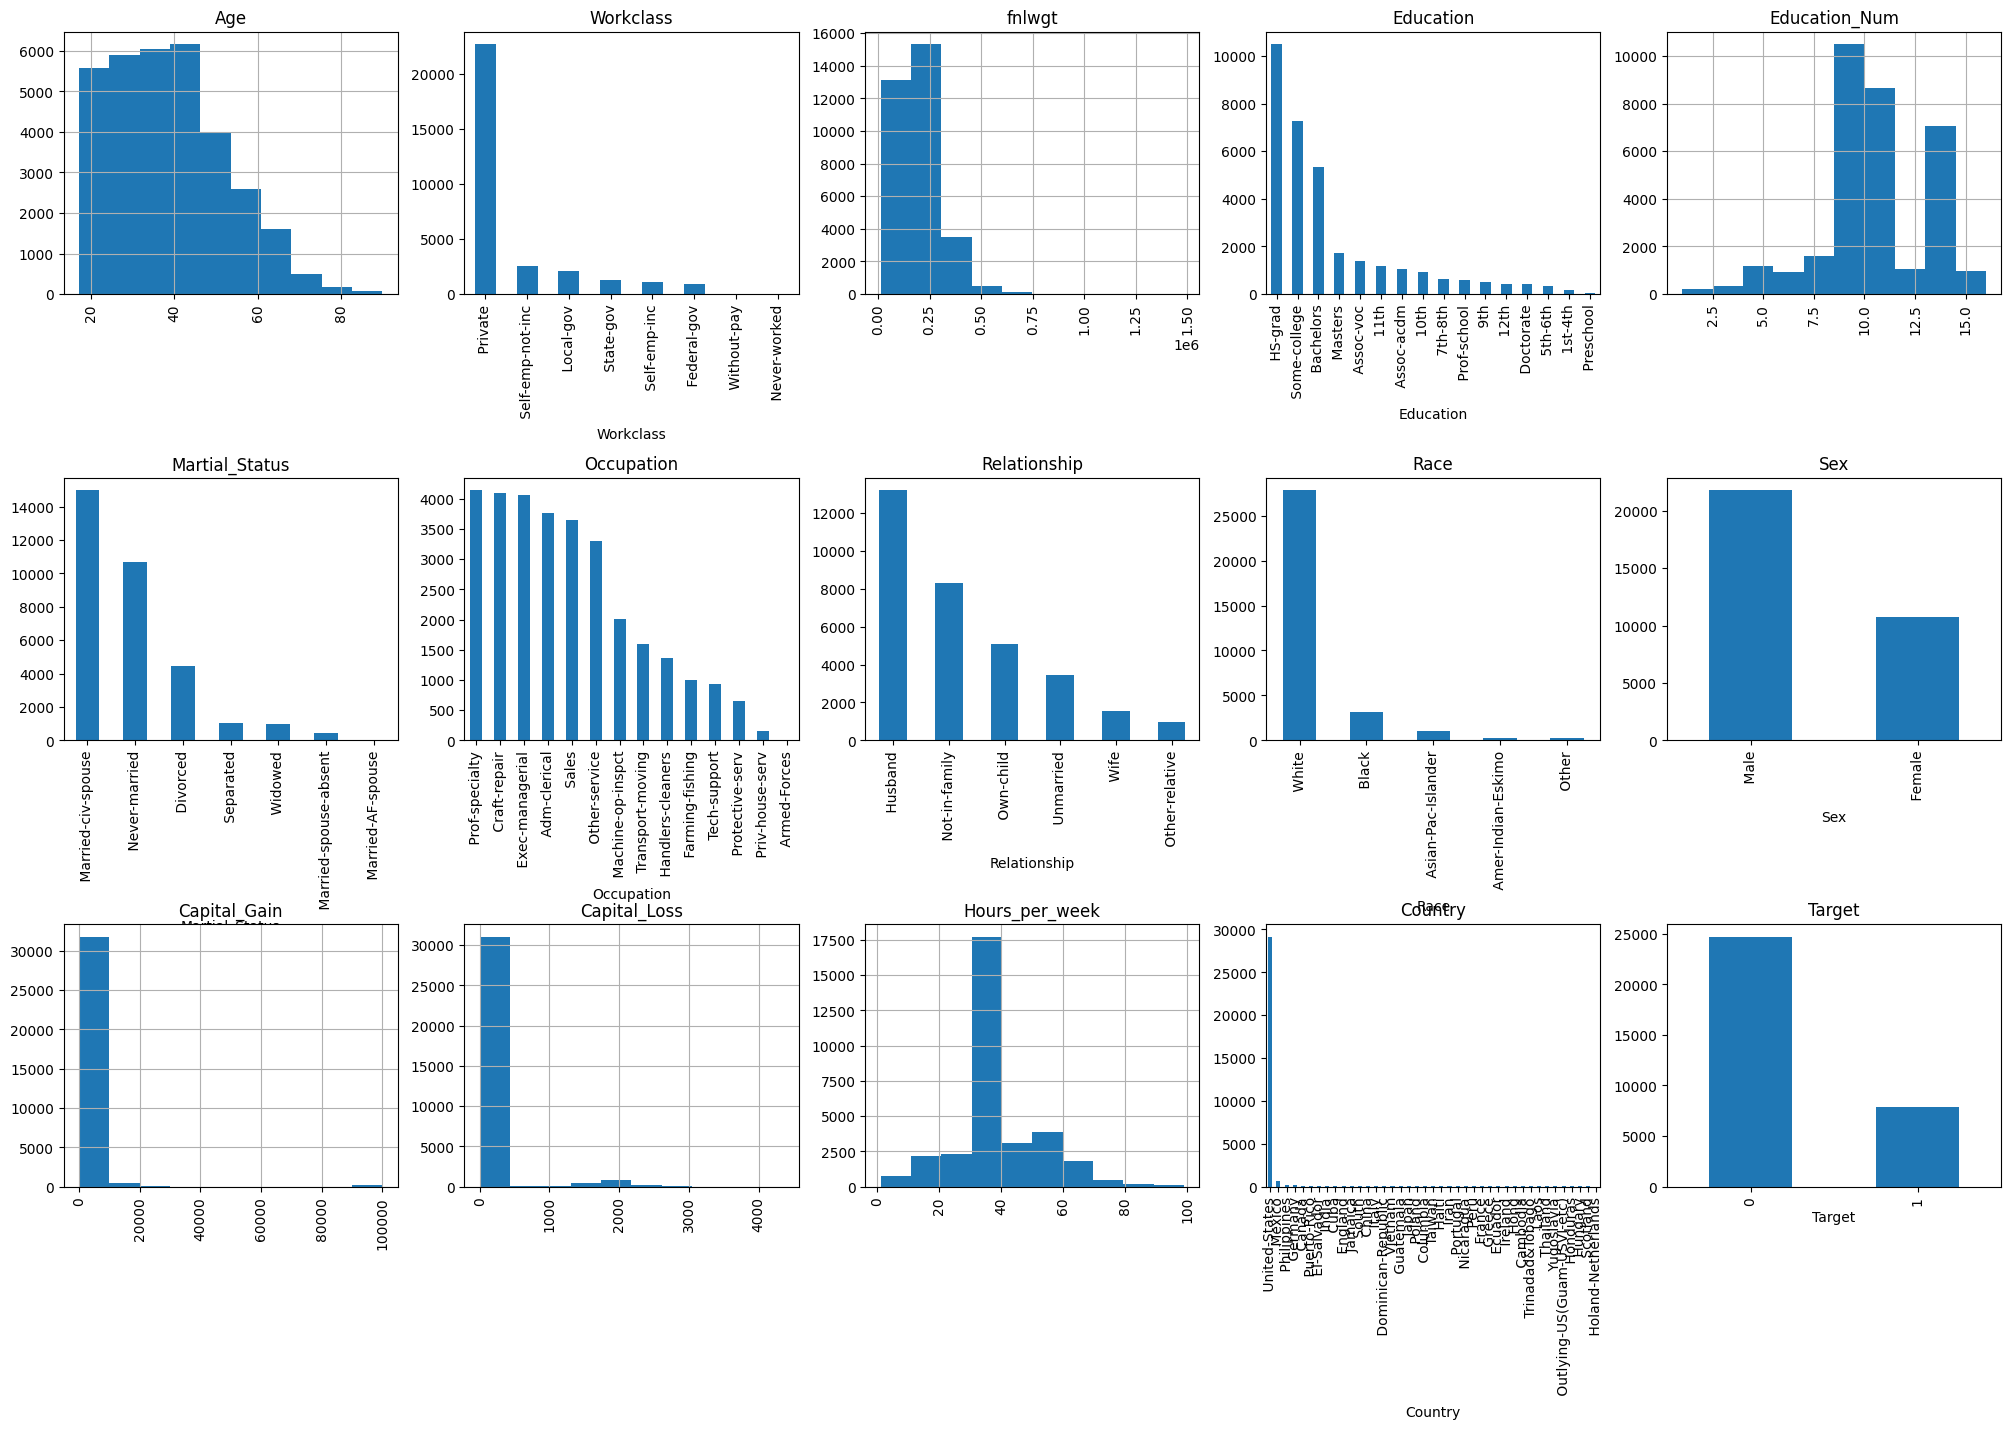

In [112]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [113]:
data_test["Age"] = data_test["Age"].astype(int)

data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

In [114]:
# отделяем целевой признак
y_train = data_train.pop('Target')
y_test = data_test.pop('Target')

In [115]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [116]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [117]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

/var/folders/n_/fptkl59n3m546hy_tw45d7lc0000gn/T/ipykernel_989/1077200075.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train[c].fillna(data_train[c].mode()[0], inplace=True)
/var/folders/n_/fptkl59n3m546hy_tw45d7lc0000gn/T/ipykernel_989/1077200075.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [118]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)


In [119]:
data_test["Country_ Holand-Netherlands"] = 0

In [120]:
X_train = data_train
X_test = data_test

In [121]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


#### 3.1 Decision tree without parameter tuning

In [ ]:
tree = DecisionTreeClassifier(random_state=17, max_depth=3)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)
accuracy_score(y_test, tree_predictions)